In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Configure inputs

In [2]:
import os
ROOT_PATH = "/content/drive/MyDrive/Colab Notebooks" # @param{type:"string"}
DATA_PATH = os.path.join(ROOT_PATH, "TCGA-data")
CLINICAL_TSV_PATH = os.path.join(DATA_PATH, "clinical.tsv")
def feature_path_for(feature_type: str) -> str:
    return os.path.join(DATA_PATH, f"X_{feature_type}.h5ad")
# SLIDE_FEATURE_PATH = os.path.join(DATA_PATH, "per_slide_X_hist.h5")

ELIGIBLE_FEATURE_TYPES = ["expr", "text", "hist_mean", "hist_max"]
os.listdir(DATA_PATH)

['X_expr.h5ad',
 'X_text.h5ad',
 'clinical.tsv',
 'per_slide_X_hist.h5',
 'X_hist_mean.h5ad',
 'X_hist_max.h5ad']

# Read data from disk

This reads all necessary data for the survival analysis, you only need to run this once

In [3]:
!pip install anndata

In [4]:
import pandas as pd
import numpy as np
import anndata

clin_data = pd.read_csv(CLINICAL_TSV_PATH, sep="\t").drop_duplicates(subset=['case_submitter_id']).set_index('case_submitter_id')
raw_feature_data_map = {}
for feature_type in ELIGIBLE_FEATURE_TYPES:
      feature_anndata = anndata.read_h5ad(feature_path_for(feature_type))
      # Hack to extract the pooling type from hist. The variable name for this
      # feature vector is just hist, even though the files are named by the pooling type
      # This hack makes it so feature names cannot contain an _, unless they mean
      # something like pooling. Sorry everyone lol
      raw_feature_data_map[feature_type] = pd.DataFrame(feature_anndata.obsm[f"X_{feature_type.split('_')[0]}"], index=feature_anndata.obs.index)

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


# Preprocess data

Set FEATURE_TYPE to one of the ELIGIBLE_FEATURE_TYPEs above. If you want to combine features, concatenate them with '+'.

DIMENSIONS_TO_KEEP sets the number of important features to be extracted using PCA. It is applied to every feature type before the features are concatenated. Set it to a negative number or very large number to leave the raw data alone.

This section also ensures that the clinical data and feature data can be harmonized. It drops any rows that are in the clinical set and not the feature set, and errors if the reverse is true.

In [5]:
from sklearn.decomposition import PCA

# FEATURE_TYPE should be a '+'-delimited list of feature types. For example,
# 'expr+text' will use appended embeddings for expression and text for clustering/PCA scatters
FEATURE_TYPE = "expr+text+hist_mean" # @param{type:"string"}
assert(ft in ELIGIBLE_FEATURE_TYPES for ft in FEATURE_TYPE.split("+"))
# For each feature type, keep the top N most important dimensions decided by PCA
DIMENSIONS_TO_KEEP = 256 # @param{type:"integer"}

def get_joined_feature_data():
    joined_feature_data = None
    feature_types = FEATURE_TYPE.split("+")
    for i, feature_type in enumerate(feature_types):
        print(f"===Preparing feature data of type {feature_type}===")
        feature_data = raw_feature_data_map[feature_type]
        if DIMENSIONS_TO_KEEP > 0 and DIMENSIONS_TO_KEEP < feature_data.shape[1]:
            print(f"Using PCA to reduce {feature_data.shape[1]} dimensions to {DIMENSIONS_TO_KEEP}")
            feature_data = pd.DataFrame(PCA(DIMENSIONS_TO_KEEP).fit_transform(feature_data), index=feature_data.index)
        print("Normalizing")
        feature_data = feature_data.apply(lambda x: x / np.linalg.norm(x), axis=1)
        print(f"Prepared feature data has shape {feature_data.shape}")
        if i == 0:
            joined_feature_data = feature_data
        else:
            joined_feature_data = joined_feature_data.join(feature_data, how="inner", lsuffix=feature_types[i-1], rsuffix=feature_type)
            print(f"Joining prepared feature data of type {feature_type} to make shape {joined_feature_data.shape}")
    return joined_feature_data

feature_data = get_joined_feature_data()
feature_data.columns = feature_data.columns.astype(str)

feature_index_set = set(feature_data.index.values)
clin_index_set = set(clin_data.index.values)
if len(feature_index_set.intersection(clin_index_set)) != len(feature_index_set):
    raise Exception("ERROR: Some features not found in clinical data")
clin_data = clin_data[clin_data.index.isin(feature_index_set)]
feature_data = feature_data.sort_index()
clin_data = clin_data.sort_index()

print(f"Feature data is a dataframe of shape {feature_data.shape}")


===Preparing feature data of type expr===
Using PCA to reduce 1280 dimensions to 256
Normalizing
Prepared feature data has shape (10117, 256)
===Preparing feature data of type text===
Using PCA to reduce 4096 dimensions to 256
Normalizing
Prepared feature data has shape (9523, 256)
Joining prepared feature data of type text to make shape (8912, 512)
===Preparing feature data of type hist_mean===
Using PCA to reduce 1024 dimensions to 256
Normalizing
Prepared feature data has shape (10066, 256)
Joining prepared feature data of type hist_mean to make shape (8862, 768)
Feature data is a dataframe of shape (8862, 768)


# Survival analysis

In [6]:
!pip install "scikit-learn==1.4.0"
!pip install scikit-survival


In [9]:
from sklearn import set_config
from sklearn.utils._set_output import _get_container_adapter
from sksurv.linear_model import CoxPHSurvivalAnalysis

import time

set_config(display="text")  # displays text representation of estimators

outcomes = clin_data[["days_to_death", "days_to_last_follow_up"]]
outcomes = outcomes.replace("'--", "-1")
outcomes = outcomes.astype(float).astype(int)
invalid_outcomes = outcomes[(outcomes["days_to_death"] < 0) & (outcomes["days_to_last_follow_up"] < 0)].index
filtered_feature_data = feature_data.drop(invalid_outcomes)
outcomes = outcomes.drop(invalid_outcomes)
print(f"Filtered out {len(invalid_outcomes)} invalid outcomes, {len(outcomes)} remaining")

outcomes["days_to_event"] = outcomes.max(axis=1)
outcomes["death_witnessed"] = outcomes["days_to_death"] != -1
print(f"{len(outcomes[outcomes['death_witnessed']])} deaths witnessed out of {len(outcomes)} total samples")
outcomes_record = outcomes[["death_witnessed", "days_to_event"]].to_records(index=False)

print("Training...")
start = time.time()
estimator = CoxPHSurvivalAnalysis(alpha=0.01)
estimator.fit(filtered_feature_data, outcomes_record)
print(f"Finished training after {time.time() - start} seconds")
score = estimator.score(filtered_feature_data, outcomes_record)
print(f"Score: {score}")

Filtered out 8 invalid outcomes, 8854 remaining
2451 deaths witnessed out of 8854 total samples
Training...
Finished training after 226.42205572128296 seconds
Score: 0.7974311019483147


# Clustering/PCA

The outputted figures use cancer type as the "definitive" clusters

In [ ]:
# Filter to only the 20 most common cancers
NUM_DIAGNOSIS = 20
# Takes a dataframe which has the submitter IDs as the index, and returns only
# cases with one of the NUM_DIAGNOSIS most common cancers, determined using clin_data
def get_common_cancer_types(df):
    id_to_diagnosis = clin_data['primary_diagnosis'].to_dict()
    diagnosis_freq = clin_data['primary_diagnosis'].value_counts().head(NUM_DIAGNOSIS)
    print(f"{sum(diagnosis_freq.values)} cases used for k={NUM_DIAGNOSIS} kmeans")
    clin_with_common_diagnosis = clin_data[clin_data['primary_diagnosis'].isin(diagnosis_freq.index.values)]

    return df[df.index.isin(clin_with_common_diagnosis.index.values)]

8980 cases used for k=20 kmeans
Features for uncommon cancers filtered out, now shape (8054, 2304)


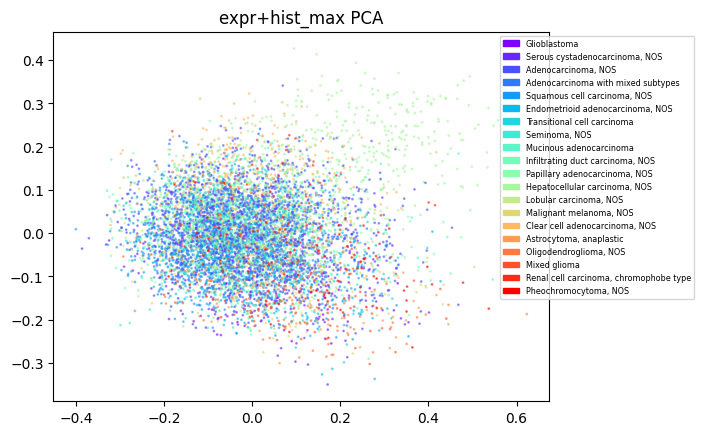

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
num_reduced_dimensions = 2
feature_data_reduced = PCA(2).fit_transform(clustering_feature_data)
color = iter(plt.cm.rainbow(np.linspace(0, 1, NUM_DIAGNOSIS)))
colormap = {}
color_array = []

for caseid in clustering_feature_data.index.values:
    diagnosis = id_to_diagnosis[caseid]
    if diagnosis not in colormap:
        colormap[diagnosis] = next(color)
    color_array.append(colormap[diagnosis])

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
feature_data_reduced_transposed = feature_data_reduced.transpose()
plt.scatter(feature_data_reduced_transposed[0], feature_data_reduced_transposed[1], c=color_array, s = 1, alpha=0.5)

handles = [mpatches.Patch(color=color, label=diagnosis) for diagnosis, color in colormap.items()]

plt.legend(handles=handles, loc="upper right", bbox_to_anchor=(1.3, 1), fontsize="xx-small")
plt.title(f"{FEATURE_TYPE} PCA")
# plt.scatter(feature_data_reduced_transposed[0], feature_data_reduced_transposed[1])
# plt.show()
# plt.savefig(f"./{FEATURE_TYPE}-pca-scatter.png")
plt.show()

In [ ]:
# Clustering for feature
from sklearn.cluster import KMeans
import time

def do_kmeans(n_clusters):
  return KMeans(n_clusters=n_clusters).fit(feature_data_reduced)

def get_kmeans_candidates(k_range):
  kmeans = []
  for i in k_range:
    start = time.time()
    print(f"Running kmeans k={i}...")
    kmeans.append(do_kmeans(i))
    print(f"Finished in {time.time() - start} seconds")
  return kmeans

In [ ]:
# Plot the elbow to demonstrate where to set K for clustering
# kmeans_range = range(10, 120, 5)
# kmeans = get_kmeans_candidates(kmeans_range)
# plt.plot(kmeans_range, list(map(lambda kmc: kmc.inertia_, kmeans)), marker='o')
# plt.show()

In [ ]:
from collections import defaultdict

diagnosis_to_label = defaultdict(list)
for caseid, label in zip(feature_data.index.values, do_kmeans(40).labels_):
  diagnosis_to_label[id_to_diagnosis[caseid]].append(label)
for key in diagnosis_to_label:
  diagnosis_to_label[key] = np.array(diagnosis_to_label[key])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


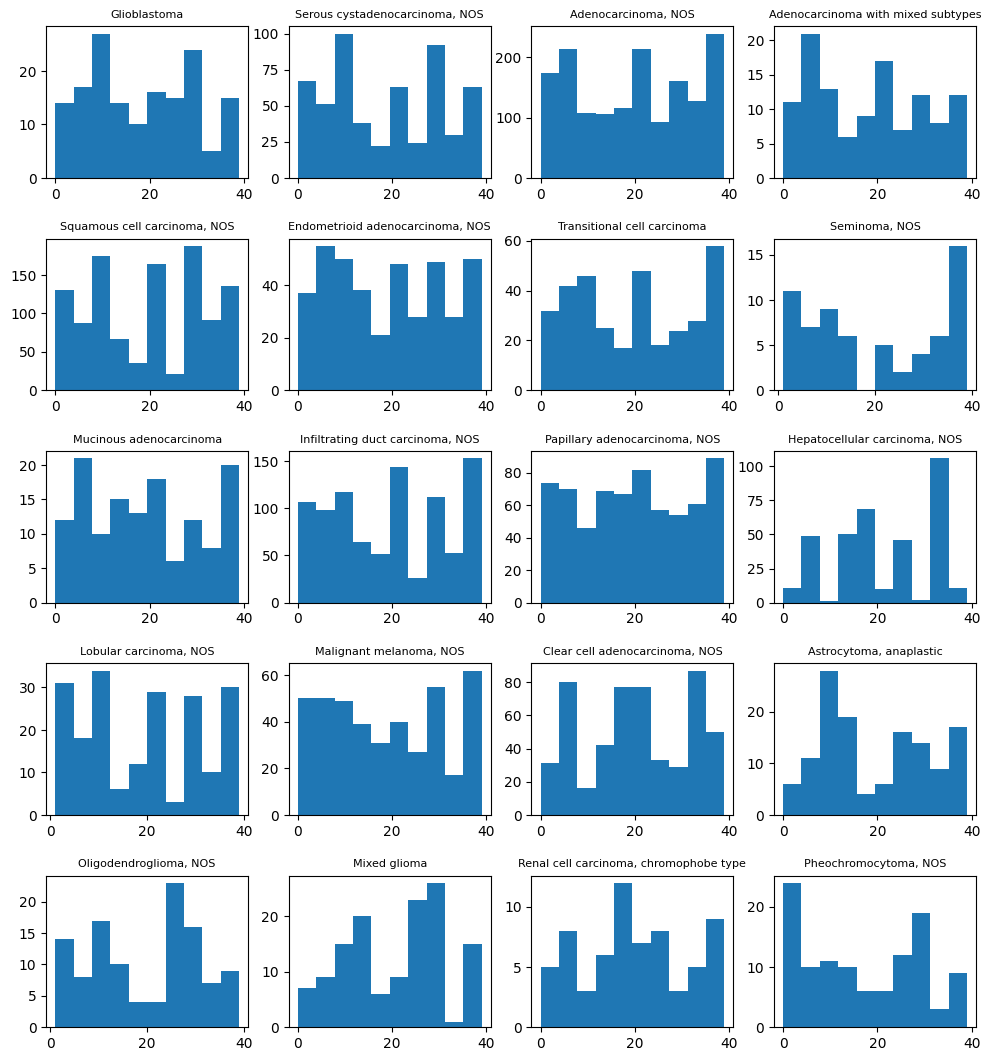

In [ ]:
fig, ax = plt.subplots(5, 4, figsize=(12, 13))
for i, key in enumerate(diagnosis_to_label):
  plt.subplot(5, 4, i+1)
  plt.hist(diagnosis_to_label[key])
  plt.title(key, fontsize=8)
plt.subplots_adjust(hspace=0.4)
plt.savefig(f"./{FEATURE_TYPE}-clusters-hist.png")
plt.show()